ALEX DVORNIKOV

HW6 PCA

In [0]:
import os
import glob
import pandas as pd
from PIL import Image
# Python Imaging Library (aka Pillow)
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import tensorflow as tf
import tensorflow_datasets as tfds

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

In [0]:
# Use Tensorflow Datasets to download the MNIST images.
mnist_data = tfds.load("mnist")
# Convert sample of tf dataset to numpy.
sample = tfds.as_numpy(mnist_data["train"].batch(60000)).__next__() # Get sample.
images = sample['image'] # images.shape = (60000,28,28,1)
images = images/images.max() # Scale the pixels between 0 and 1
labels = sample['label'] # labels.shape = (60000, )

# One hot encode the labels 
types= np.unique(labels)
labels_one_hot = tf.keras.backend.one_hot(labels, num_classes=10)
# labels_one_hot = pd.get_dummies(labels, columns=types)
labels_idx = np.argmax(labels_one_hot, axis=1) # Get label as integer.

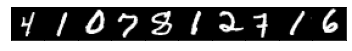

In [0]:
# Show some images.
fig,ax = plt.subplots(1,10, gridspec_kw = {'wspace':0, 'hspace':0}) 
for i in range(0,10,1):
  ax[i].imshow(images[i,:,:,0], cmap=plt.get_cmap('binary_r'))
# Clear the tick marks. 
# Setp (set properties) of the figure. 
# The get_axes() are deprecated but still work. 
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);

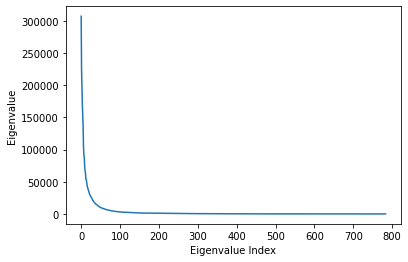

In [0]:
# Define a matrix
X = images # At this point X.shape -> (6e4, 28, 28, 1)
N = X.shape[0] # Number of images 
# Flatten each image to a vector
X = X.reshape(N,-1) # Here X.shape -> (6e4, 784)

# Calculate the mean of each column (image) and subtract it out (from each image). 
# Generaly, for numpy arrays. 
# axis = 0 -> Columns
# axis = 1 -> Rows 
mu = np.mean(X, axis=0)
X  = X - mu

# Calculate the covariance matrix.
C = X.T.dot(X) #Shape -> (784, 784)

# Get the e-vals and e-vecs of the covariance matrix. 
# E-vals shape -> (784,). One e-val for each e-vec. 
# E-vecs shape -> (784, 784). Each has a shape -> (784,)
eigenvalues, eigenvectors = np.linalg.eig(C)

# Sort the e-vals and e-vecs by the e-val (from max to min).
a = eigenvalues.argsort()[::-1] # Returns the indices that would sort the array (max to min).
eigenvalues = eigenvalues[a]
eigenvectors = eigenvectors[a] # Column (e-vec) i corresponds to the ith e-val.
eigenvectors = np.real(eigenvectors) # Ignore complex (imaginary) parts.

# Visual check (that we sorted the e-vals from max to min)
plt.plot(eigenvalues)
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.show()

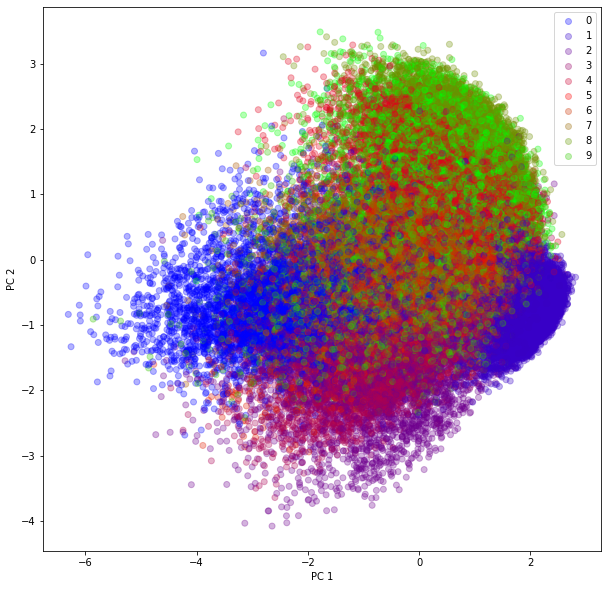

In [0]:
# Project the data onto the first k principal components.
# For now try 2D 
k = 2
# P is (6e4,k). Every image has k projection values. 
P = X.dot(eigenvectors[:,:k])
plt.figure(1, figsize=(10,10))
# plt.figure(1) # Need to index the figures if printing a multiple number of them from a single cell. 
# Color the Pokemon by type to see if clusters emerge (create a colorscale from 0 to 1)
scatter = plt.scatter(P[:,0], P[:,1], c=labels_idx/labels_idx.max(), cmap='brg', alpha=0.3)
# Label the colors.
legend1 = plt.legend(scatter.legend_elements()[0], types)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

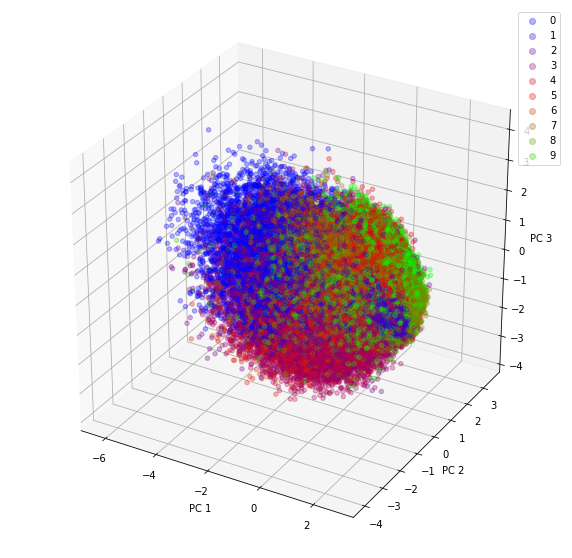

In [0]:
# 3D Plot 
k = 3
P = X.dot(eigenvectors[:,:k])
fig = plt.figure(2, figsize=(10,10))
# fig = plt.figure(2)
ax = fig.add_subplot(111, projection='3d')
# 111 in add_subplot corresponds to the 1st element of a 1x1 plot grid
# 223 would correspond to the 3rd (bottom left) element of a 2x2 plot grid 
scatter = ax.scatter(P[:,0], P[:,1], P[:,2], c=labels_idx/labels_idx.max(), cmap='brg', alpha=0.3)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
legend1 = plt.legend(scatter.legend_elements()[0], types)

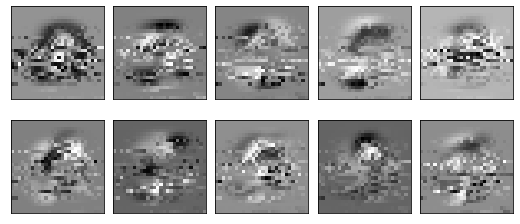

In [0]:
# Visualize the handwritten digits principal components.
fig, axes = plt.subplots(2, 5, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
  # Reshape the e-vecs (PCs) (of length = 784) back into 28x28 images and visualize them. 
  ax.imshow(eigenvectors[:,i].reshape(28, 28), cmap='binary_r')

The top 10 PCs have many pixels and seem to emphasize various parts of a handwritten digit (upper or lower loops, or vertical or horizontal lines, etc). 

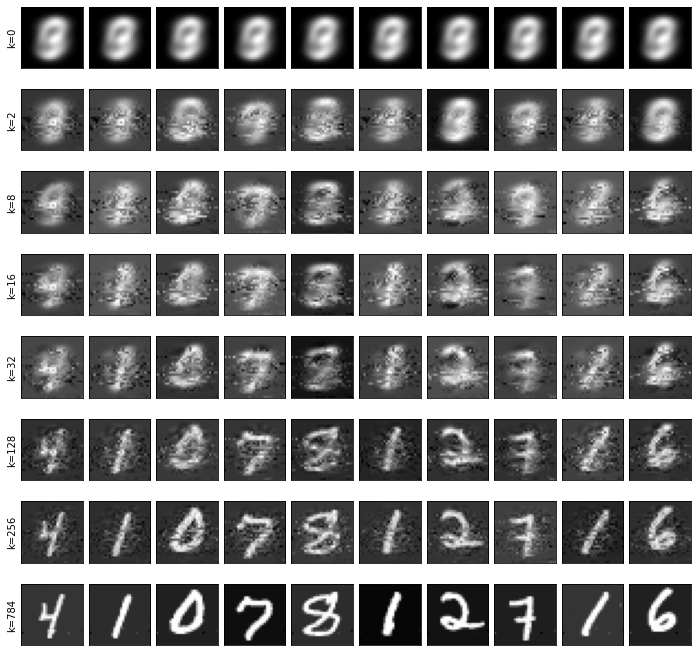

In [0]:
# Plot the projections for increasing k values.
k_values = [0, 2, 8, 16, 32, 128, 256, 784]

fig, ax = plt.subplots(len(k_values), 10, figsize=(12, 12),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))

for j,k in enumerate(k_values):
  projected = X.dot(eigenvectors[:,:k]).dot(eigenvectors[:,:k].T) + mu
  # Do this for the first 10 handwritten digits.
  for i in range(10):
    ax[j, i].imshow(projected[i].reshape(28,28), cmap='binary_r')
  ax[j, 0].set_ylabel(f'k={k}');

The handwritten digits become recognizable after about 16 PCs. 

PART 2: TRANSFER LEARNING

EMBED POKEMON IMAGES IN BOTH THE POKEMON AND MNIST PRINCIPAL COMPONENTS.

COMPARE THE ERRORS. 

In [0]:
# Get the Pokemon images from Peter's github. 
!git clone https://github.com/peterjsadowski/pokemon_pca.git 

# Only keep Pokemon for which we have images and meta data.
filenames = [f[2] for f in os.walk('./pokemon_pca/data/images/')][0]
pokemon_names = [f.split('/')[-1].split('.')[0] for f in filenames]
df = pd.read_csv('./pokemon_pca/data/pokemon.csv', index_col=0)

# One hot encode the pokemon's primary type
pokemon_types= df['Type1'].unique()
labels_names = df['Type1']
labels_one_hot_pokemon = pd.get_dummies(labels_names, columns=pokemon_types)
labels_idx_pokemon = np.argmax(labels_one_hot_pokemon.to_numpy(), axis=1) # Get label as integer.

In [0]:
# Grab the Pokemon images and save them to a list.
# Will only use the black and white versions. 
imgs = []
gray_imgs = []
for name in df.index: # df.index gives the row labels of the data frame 
  filename = glob.glob(f'./pokemon_pca/data/images/{name}.*')[0]
  
  # Open the image with PIL and save it as grayscale color and grayscale but in RGB format
  img = Image.open(filename).convert('RGB') # Some are RGBA so we convert them
  imgs.append(np.array(img))
  # Save a gray scale version.
  gray_img = np.array(img.convert('L') )
  if gray_img[0,0] == 255:
    gray_img = 255 - gray_img # Invert colors. Example 9 had this problem.
  # Crop (weird edge effects on bottom)
  gray_img = gray_img[15:99,15:99]
  # Downsample (makes pca faster).
  input_size, output_size = 84, 28
  bin_size = input_size // output_size
  gray_img = gray_img.reshape((output_size, bin_size, output_size, bin_size)).max(3).max(1)
  gray_imgs.append(gray_img)

# Convert lists to numpy arrays.
imgs = np.array(imgs)
gray_imgs = np.array(gray_imgs)
gray_imgs = np.expand_dims(gray_imgs, axis=-1)
# Scale the image pixels to range between 0 and 1
gray_imgs = gray_imgs/gray_imgs.max()
# print(imgs.shape, gray_imgs.shape)

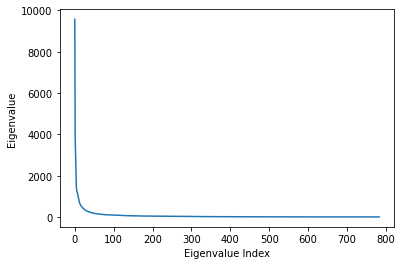

In [0]:
# Define a matrix
X_pokemon = gray_imgs # At this point X.shape -> (809, 28, 28, 1)
N_pokemon = X_pokemon.shape[0] # Number of images 
# Flatten each gray scale image to a vector
X_pokemon = X_pokemon.reshape(N_pokemon,-1) # Here X.shape -> (809, 784)

# Calculate the mean of each column (image) and subtract it out (from each image). 
# Generaly, for numpy arrays. 
# axis = 0 -> Columns
# axis = 1 -> Rows 
mu_pokemon = np.mean(X_pokemon, axis=0)
X_pokemon  = X_pokemon - mu_pokemon

# Calculate the covariance matrix.
C_pokemon = X_pokemon.T.dot(X_pokemon) #Shape -> (784, 784)

# Get the e-vals and e-vecs of the covariance matrix. 
# E-vals shape -> (784,). One e-val for each e-vec. 
# E-vecs shape -> (784, 784). Each has a shape -> (784,)
eigenvalues_pokemon, eigenvectors_pokemon = np.linalg.eig(C_pokemon)

# Sort the e-vals and e-vecs by the e-val (from max to min).
a = eigenvalues_pokemon.argsort()[::-1] # Returns the indices that would sort the array (max to min).
eigenvalues_pokemon = eigenvalues_pokemon[a]
eigenvectors_pokemon = eigenvectors_pokemon[a] # Column (e-vec) i corresponds to the ith e-val.
eigenvectors_pokemon = np.real(eigenvectors_pokemon) # Ignore complex (imaginary) parts.

# Visual check (that we sorted the e-vals from max to min)
plt.plot(eigenvalues_pokemon)
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.show()

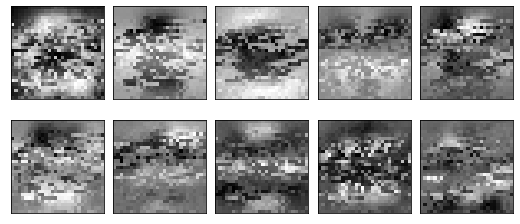

In [0]:
# Visualize the Pokemon principal components.
fig, axes = plt.subplots(2, 5, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
  # Reshape the e-vecs (PCs) (of length = 784) back into 28x28 images and visualize them. 
  ax.imshow(eigenvectors_pokemon[:,i].reshape(output_size, output_size), cmap='binary_r')

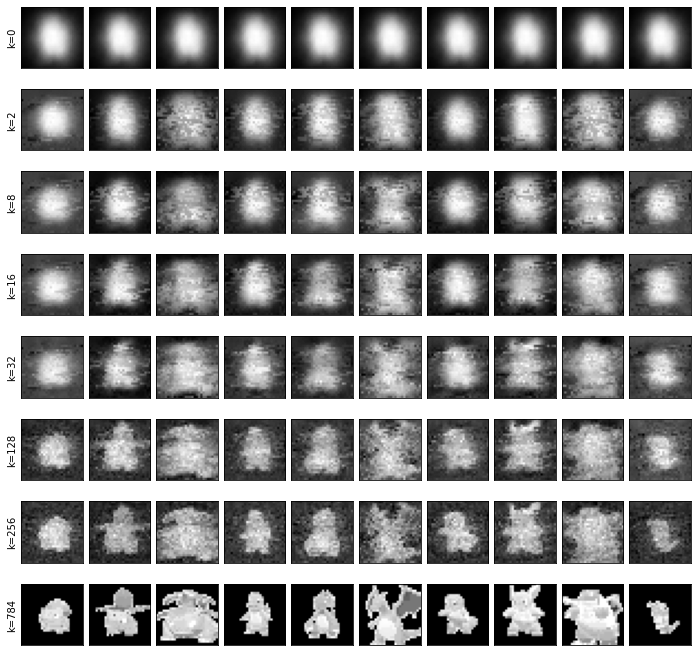

In [0]:
# Plot the projections for increasing k values.
k_values = [0, 2, 8, 16, 32, 128, 256, 784]

fig, ax = plt.subplots(len(k_values), 10, figsize=(12, 12),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))

for j,k in enumerate(k_values):
  projected_pokemon = X_pokemon.dot(eigenvectors_pokemon[:,:k]).dot(eigenvectors_pokemon[:,:k].T) + mu_pokemon
  # Do this for the first 10 Pokemon.
  for i in range(10):
    ax[j, i].imshow(projected_pokemon[i].reshape(output_size,output_size), cmap='binary_r')
  ax[j, 0].set_ylabel(f'k={k}');

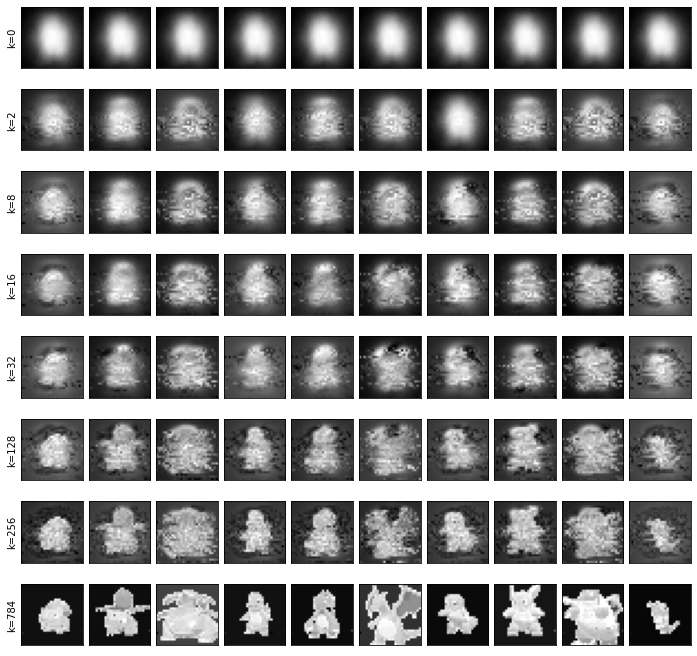

In [0]:
# Plot the projections to MNIST for increasing k values.
k_values = [0, 2, 8, 16, 32, 128, 256, 784]

fig, ax = plt.subplots(len(k_values), 10, figsize=(12, 12),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))

for j,k in enumerate(k_values):
  projected_pokemon2MNIST = X_pokemon.dot(eigenvectors[:,:k]).dot(eigenvectors[:,:k].T) + mu_pokemon
  # Do this for the first 10 Pokemon.
  for i in range(10):
    ax[j, i].imshow(projected_pokemon2MNIST[i].reshape(output_size,output_size), cmap='binary_r')
  ax[j, 0].set_ylabel(f'k={k}');

The reconstructed Pokemon are very similar regardless of the PC projection (whether the PCS are extracted from the Pokemon images or handwritten digits). Below is a quantitative (tabulated) assesment (the error depending on the PC projections). 

In [0]:
#Calculate the error (using both the Pokemon PCs and the MNIST PCs).

# Retrieve the input Pokemon images. 
# Add back the mean to the pokemon images (for a correct comparison to the reconstructed images )
pokemon_imgs = X_pokemon + mu_pokemon

# Calculate the error (Mean Sum of Squares). Why? 
# The PCS maximize the variance by minimizing the sum of squares.
error_pokemon, error_MNIST = [], []
k_values = [0, 2, 8, 16, 32, 64, 128, 256, 512, 784]
for k in k_values: 
  projected_pokemon = X_pokemon.dot(eigenvectors_pokemon[:,:k]).dot(eigenvectors_pokemon[:,:k].T) + mu_pokemon
  projected_pokemon2MNIST = X_pokemon.dot(eigenvectors[:,:k]).dot(eigenvectors[:,:k].T) + mu_pokemon

  error_temp_pokemon = np.sum( np.square( pokemon_imgs - projected_pokemon ) )/N_pokemon
  error_temp_MNIST = np.sum( np.square( pokemon_imgs - projected_pokemon2MNIST ) )/N_pokemon

  error_pokemon.append( error_temp_pokemon )
  error_MNIST.append( error_temp_MNIST )

# Print the errors vs. k (using a Pandas dataframe)
# Note: k corresponds to the number of PCs. 
d = {'k':k_values,'Error (Pokemon PCs)':error_pokemon, 'Error (MNIST PCs)':error_MNIST}
df = pd.DataFrame(d)
print(df.round(1).to_string(index=False))

   k  Error (Pokemon PCs)  Error (MNIST PCs)
   0                 69.9               69.9
   2                 57.8               65.7
   8                 50.9               60.7
  16                 46.7               56.9
  32                 42.7               52.9
  64                 38.5               47.1
 128                 32.9               38.3
 256                 24.2               27.3
 512                 10.0               12.2
 784                  0.0                0.1


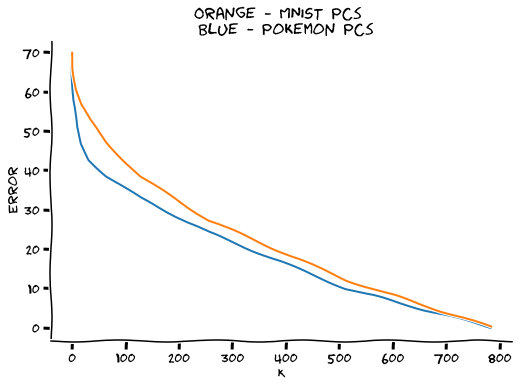

In [116]:
# Turns out Python has built in XKCD styling :D
with plt.xkcd():

    fig = plt.figure()
    ax = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.plot( k_values, error_pokemon)
    ax.plot( k_values, error_MNIST )
    ax.set_title('Orange - MNIST PCs \n Blue - Pokemon PCs')
    ax.set_xlabel('K')
    ax.set_ylabel('Error')
    fig.set_size_inches(8, 6)

In [0]:
# This block has a great Plotly style (but it does not render on Github)
# Unfortunately, Github can only render static plots for now. 
# This runs on Colab and/or locally (if you are interested). 

# fig = go.Figure()
# fig.add_trace(go.Scatter(x=k_values, y=error_pokemon,
#                     mode='lines+markers',
#                     name='Pokemon PCs',
#                     marker_color='black'))
# fig.add_trace(go.Scatter(x=k_values, y=error_MNIST,
#                     mode='lines+markers',
#                     name='MNIST PCs',
#                     marker_color='magenta'))

# fig.update_xaxes(tickfont=dict(family='Rockwell', color='black', size=18))
# fig.update_yaxes(tickfont=dict(family='Rockwell', color='black', size=18))
# fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
# fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
# fig.update_xaxes(title_text = 'K', title_font=dict(size=18, family='Rockwell', color='black'))
# fig.update_yaxes(title_text = 'Error (Sum of Squares Mean)', title_font=dict(size=18, family='Rockwell', color='black'))

# fig.update_layout(width=800, height=600)
# fig.update_layout(legend=dict(font=dict(size=18, family='Rockwell', color='black')))
# # The line below forces a white background.  
# # fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)','paper_bgcolor': 'rgba(0, 0, 0, 0)',})

# fig.show()